# Lidl Product Association Generator
Imagine you are a small store owner. Your customer is browsing your website and starts to hesitate. "Should I buy another apple for my kid or a pair of socks for my husband?", she thinks. You look at this crafty Lidl recommendation engine and you try to use it for your own purposes. After all, apples there and at your store are not that different. Works fine!

But after a few trials, you notice you got rate limited. Lidl's webiste got out of queries for you! Well, if you just got pale, I suggest you do not fret more. This notebook will give you a solution.

But before, let us start with setting up everything we need.

## Setup
Below we import a set of necessary modules, such as Tensorflow or Python Imaging Library, that propel the code. We use `tqdm.pandas` to visualize the progress of some of the operations we conduct. The **DataIO** class is responsible for loading and saving files in different formats. **LidlProductGatherer** provides a structure for our structured and unstructured data scraping, including the download of images, and parsing the data into a easy-to-read format. It is linked with the **ElementSpec** to represent and act upon the configuration specific to Lidl HTML attributes (e.g. class names).

In [1]:
import dill as pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import json
tqdm.pandas()

In [2]:
class DataIO:
    "Performs common I/O operations on files."
    
    def __init__(self):
        self.modes = ("r", "rb", "w", "wb", "a")
        self.readables = tuple(
            mode for mode in self.modes if mode.startswith("r"))
        self.writables = tuple(
            mode for mode in self.modes if not mode.startswith("r"))
        self.binaries = tuple(
            mode for mode in self.modes if mode.endswith("b"))
    
    def _do_io(self, filepath, /, file=None, mode=None, restricted=None,
               default_mode="rb", operation=None):
        """Perform necessary I/O operations."""
        if restricted is None:
            restricted = self.modes
        if mode not in restricted:
            mode = default_mode
        if not operation and mode in self.binaries:
            if file is None:
                operation = pickle.load
            else:
                operation = lambda handle: pickle.dump(file, handle)
        with open(filepath, mode) as handle:
            return operation(handle)
    
    def load(self, filepath, /, mode=None, loader=None):
        """Load any file."""
        return self._do_io(
            filepath, mode=mode, restricted=self.readables,
            operation=loader
        )

    def save(self, saved, filepath, /, mode=None, saver=None):
        """Save any file."""
        self._do_io(
            filepath, file=saved, mode=mode, restricted=self.writables,
            operation=saver, default_mode = "wb"
        )

    def loadf(self, filepath):
        """Load pickled file."""
        return self.load(filepath)

    def savef(self, saved, filepath):
        """Save file with pickle."""
        self.save(saved, filepath)

    def savec(self, saved, filepath):
        """Save class."""
        obj = (saved.__class__.__name__, saved.__dict__)
        self.save(obj, filepath)
    
    def loadc(self, filepath):
        """Load class."""
        loaded = self.load(filepath)
        name, attrs = loaded
        cls = globals()[name]
        instance = cls(preload=True)
        for attr in attrs:
            setattr(instance, attr, attrs[attr])
        return instance

    def loady(self, filepath):
        from yaml import safe_load
        return self.load(filepath, mode="r", loader=safe_load)

In [3]:
class ElementSpec:
    """Specifies the name, class, actions for a specific element on the website."""

    def __init__(self, specifier, value, label=None, attrib=None):
        self.specifier = specifier
        self.value = value
        self.label = label if label else value
        self.attrib = attrib

    def __repr__(self):
        return (
            f"{self.__class__.__name__}(specifier={self.specifier}, "
            f"value={self.value}, label={self.label}, attrib={self.attrib})"
        )
    
    def to_dict(self):
        return {self.specifier: self.value}

    def invokeAction(self, el, default="text"):
        if self.attrib:
            return el.get(self.attrib)
        if default:
            return getattr(el, default)

In [4]:
class LidlProductGatherer:
    def __init__(self, source=None, source_conf=None, preload=False):
        self.io = DataIO()
        if not preload:
            self.BASE_PATH = Path.cwd()
            self.used_product_ids = set()
            self.source_conf = self.io.loady(source_conf) if source_conf is not None else {}
            self.source = source if source is not None else self.source_conf["source"]
            self.element_identifiers = [ElementSpec(**iden) for iden in self.source_conf.pop("identifiers", [])]
            self.source_conf["absolute_path"] = self.get_source_protocol_host()
            self.self_save_fp = self.BASE_PATH / "LPG.pkl"
            self.images_path = Path(self.source_conf["base_img_dir"])
    
    def grab_page(self, url, raise_for_status=False):
        try:
            r = requests.get(url)
            if raise_for_status:
                r.raise_for_status()
        except requests.exceptions.ConnectionError:
            return None, None
        soup = BeautifulSoup(r.text)
        timestamp = pd.Timestamp(r.headers["Date"])
        return soup, timestamp
    
    def parse_part(self, part, identifiers):
        part_info = {}
        if part:
            for i in identifiers:
                el = part.find(**i.to_dict())
                if el:
                    part_info[i.label] = i.invokeAction(el)
        return part_info

    def generate_parts(self, base_el, obj_of_interest):
        items = base_el.findAll(**obj_of_interest.to_dict())
        return items
    
    def use_parts(self, parts, **kwargs):
        results = []
        for p in parts:
            result = self.parse_part(p, **kwargs)
            results.append(result)
        return pd.DataFrame(results)
    
    def get_extra_info_for_base_products(self, products, identifiers):
        extra_info_map = {}
        for idx, link in products.Link.iteritems():
            product_soup, request_time = self.grab_page(link)
            info = self.parse_part(product_soup, identifiers)
            info["Timestamp"] = request_time
            extra_info_map[idx] = info
        extra_info = pd.DataFrame(extra_info_map).T
        return extra_info

    def load_source(self, source=None, source_basis=None):
        if source is None:
            source = self.source
        if source_basis is None and self.source_conf:
            source_basis = ElementSpec(**self.source_conf["source_basis"])
        source_soup, ts = self.grab_page(source)
        source_products = self.generate_parts(source_soup, source_basis)
        products = self.use_parts(
            source_products, identifiers=self.element_identifiers
        )
        products = self.standardize(products)
        product_page_extra_identifiers = [
            ElementSpec("class_", "buybox__erp-number", label="ProductNo"),
            ElementSpec("class_", "keyfacts__description", label="Notes"),
        ]
        product_page_extra_info = self.get_extra_info_for_base_products(
            products,
            product_page_extra_identifiers
        )
        products = self.merge(products, product_page_extra_info)
        self.element_identifiers += product_page_extra_identifiers
        self.products = products
        self.io.savec(self, self.self_save_fp)

    def get_source_protocol_host(self):
        url_parts = urlparse(self.source)
        return f"{url_parts.scheme}://{url_parts.netloc}"
    
    def standardize(self, table, link_col_name="Link"): 
        table = table.dropna(how="all").reset_index(drop=True)
        if link_col_name in table:
            abs_path = self.source_conf["absolute_path"]
            link_col = table[link_col_name]
            link_col = link_col[~link_col.str.startswith("http")]
            table.loc[link_col.index, link_col_name] = abs_path + link_col
        return table
    
    @staticmethod
    def merge(left, right):
        return left.join(right)
    
    def get_recommendations(self, product_ids):
        frames = []
        for id_ in product_ids:
            if not pd.isnull(id_):
                url = self.source_conf["recommendation_source"] + str(int(id_))
                try:
                    r = requests.get(url)
                except requests.exceptions.RequestException:
                    continue
                recs = json.loads(r.text)
                recs = pd.DataFrame(recs["recommendationItems"])
                recs.columns = recs.columns.str.capitalize()
                recs = recs.add_prefix("rec").assign(orgItemId=id_)
                frames.append(recs)
        result = pd.concat(frames, ignore_index=True)
        return result

    def get_products_info(self, product_ids, identifiers):
        info_map = {}
        for idx, id_ in tqdm(enumerate(product_ids), total=len(product_ids)):
            url = self.source_conf["product_source"] + str(int(id_))
            product_soup, request_time = self.grab_page(url)
            if product_soup:
                product_soup = product_soup.find(class_="detail")
                info = self.parse_part(product_soup, identifiers)
                info["Timestamp"] = request_time
                info_map[id_] = info
        info = pd.DataFrame(info_map).T.reset_index().rename(columns={"index": "ProductNoFromRec"})
        return info
    
    def gather(self, limit=1000):
        try:
            self.products
        except AttributeError:
            self.load_source()

        self.element_identifiers += [
            ElementSpec("class_", "keyfacts__title", label="Title2"),
            ElementSpec("id", "detailtab1", label="Description"),
            ElementSpec("class_", "rating-histogram-table", label="Rating")
        ]
        with tqdm(total=limit) as pbar:
            pbar.update(len(self.products))
            while len(self.products) <= limit:
                prev_len = len(self.products)
                self.recs = self.get_recommendations(self.products.ProductNo)
                additional_product_ids = set(
                    self.recs.recItemid.unique()
                ) - self.used_product_ids
                print(len(additional_product_ids))

                new = self.get_products_info(
                    additional_product_ids,
                    self.element_identifiers
                )
                self.products = pd.concat([self.products, new], ignore_index=True)
                self.products["ProductNo"] = self.products[
                    "ProductNo"
                ].fillna(self.products.ProductNoFromRec)
                self.used_product_ids.update(additional_product_ids)
                self.io.savec(self, self.self_save_fp)
                pbar.update(len(self.products) - prev_len)

    def download_image(self, row, allow_repetitions=False):
        if isinstance(row, str):
            image_links
        image_links = (row["Image"], row["Image2"])
        for link in image_links:
            try:
                r = requests.get(link)
                r.raise_for_status()
            except requests.exceptions.RequestException:
                continue
            c_type = r.headers["content-type"]
            if c_type in ("image/jpg", "image/jpeg"):
                img = r.content
                fp = Path(f"{self.images_path}/{row['ProductNo']}.{c_type.split('/')[1]}")
                exists = fp.exists()
                if not exists:
                    with open(fp, "wb") as file:
                        file.write(img)
                if allow_repetitions or not exists:
                    row["ImageFile"] = fp
                    
        return row
    # allow rep = not write + row fp
    # 

    def download_images(self):
        if not self.images_path.exists():
            self.images_path.mkdir(parents=True)
        self.products.progress_apply(self.download_image, axis=1)
    
    def unify_products(self):
        products = self.products
        products = products.dropna(subset=["Link"]).reset_index(drop=True)
        products["Title"] = products["Title"].str.strip()
        products["Title2"] = products["Title2"].str.strip()
        products["Title"] = products["Title"].fillna(products["Title2"])
        products["PriceOld"] = products["PriceOld"].str.strip().str.replace(
            " zł", "").str.replace(",", ".").astype(float)
        products["PriceNew"] = products["PriceNew"].str.strip().str.replace(
        ",", ".").astype(float)

        def take_first_list_item(l):
            return l[0] if isinstance(l, list) else l

        products["Quantity"] = products["Quantity"].str.strip()
        products.loc[~(products["Quantity"].str.contains(r"[0-9]").fillna(False)), "Quantity"] = None
        products["Quantity"] = products["Quantity"].str.split('\n').apply(take_first_list_item).str.split('/').apply(take_first_list_item).str.replace("za ", "")
        products.loc[products["Quantity"].str.contains(r"=").fillna(False), "Quantity"] = None
        products["Quantity"] = products["Quantity"].str.replace("-", " ")
        products[["Quantity", "Unit"]] = products["Quantity"].str.split(expand=True)
        links = products.Link[products.Link.str.slice(0, 21).str.endswith("p")]
        products.loc[products.Link.str.startswith("https://api.whatsapp.com") | products.Link.str.startswith("#") | links.astype(bool), "Link"] = None
        products = products.rename(columns={"Link": "Image2"})
        self.products = products
    
    def get_sample_image_filepath(self):
        for spec in self.element_identifiers:
            if spec.value == "img":
                break
        while True:
            try:
                link, pno = self.generate_sample_product_link()
                soup, _ = self.grab_page(link, raise_for_status=True)
                break
            except requests.exceptions.HTTPError:
                pass
        soup = soup.find(class_="detail")
        product = self.parse_part(soup, [spec])
        product = self.download_image({**product, "Image2": None, "ProductNo": pno}, allow_repetitions=True)
        return product["ImageFile"]
    
    def generate_sample_product_link(self):
        freq_pno_4s = int(self.products.ProductNo[
            self.products.ProductNo.str.startswith('1')
        ].str.slice(0, 4).value_counts().index[0])
        mpl = 10 ** 5
        pno = np.random.randint(freq_pno_4s * mpl, (freq_pno_4s + 1) * mpl - 1)
        return self.source_conf["product_source"] + str(pno), pno

# Data Scraping
In this section, we load the configuration, and scrape the product info as well as the product images, which will form the basis of our subsequent analysis. We save the dataframe with the results as the `LPG.pkl` file.

In [5]:
gatherer = LidlProductGatherer(source_conf="config.yaml")

In [6]:
gatherer.load_source()

In [7]:
gatherer.gather()

  0%|          | 0/1000 [00:00<?, ?it/s]

150


  0%|          | 0/150 [00:00<?, ?it/s]

995


  0%|          | 0/995 [00:00<?, ?it/s]

In [8]:
gatherer.unify_products()

In [9]:
gatherer.download_images()

  0%|          | 0/1158 [00:00<?, ?it/s]

In [10]:
gatherer.products.head()

,Title,Image,PriceOld,PriceNew,Quantity,Image2,ProductNo,Timestamp,Notes,ProductNoFromRec,Title2,Description,Unit
0,"Papryka czerwona, luzem",https://pl.cat-ret.assets.lidl/catalog5media/p...,14.27,8.99,1,None,82615,2022-03-26 16:04:11+00:00,NaN,NaN,NaN,NaN,kg
1,"Kiwi, luzem",https://pl.cat-ret.assets.lidl/catalog5media/p...,1.41,0.79,100,None,80675,2022-03-26 16:04:12+00:00,NaN,NaN,NaN,NaN,g
2,Polskie buraki gotowane,https://pl.cat-ret.assets.lidl/catalog5media/p...,3.80,2.47,500,None,82825,2022-03-26 16:04:12+00:00,"cena regularna: 3,80/1 opak.cena przy zakupie ...",NaN,NaN,NaN,g
3,"Polska marchew, luzem",https://pl.cat-ret.assets.lidl/catalog5media/p...,2.84,1.89,1,None,82755,2022-03-26 16:04:13+00:00,NaN,NaN,NaN,NaN,kg
4,"Banany dla dzieci, luzem",https://pl.cat-ret.assets.lidl/catalog5media/p...,NaN,7.13,1,None,80010,2022-03-26 16:04:13+00:00,NaN,NaN,NaN,NaN,kg


In [10]:
DataIO().savec(gatherer, gatherer.self_save_fp)

# Establishing graph connections
To be able to approximate the recommendations for new products, we need to look into the ways the the product recommendations are established. In order to do so, I am going to create a graph with products shown as nodes and the edges representing the connections between the original product and the recommendations provided by Lidl's engine associated with that product. Once, the connections get uncovered, the communities will be determined within the graph using greedy modularity algorithm. The community feature will be the target variable in the model. On the graph drawn below, these communities are shown by coloring the nodes in different hues.

We merge the communities with the product dataframe using the `link_products` function so that we can use them in the model.

In [11]:
gatherer = DataIO().loadc("LPG.pkl")

In [15]:
class GraphGenerator():
    def __init__(self, recommendations, source=None, target=None):
        self.edge_attr = True
        self.G = nx.from_pandas_edgelist(
            recommendations, source=source, target=target, edge_attr=self.edge_attr
        )
    def derive_community(self):
        module_nodes = nx.community.greedy_modularity_communities(self.G)
        community_modules = {n: ic for ic, c in enumerate(module_nodes) for n in c}
        self.comm_array = np.asarray([community_modules[n] for n in self.G.nodes()])
        return pd.Series(community_modules, name="Community")

    def draw(self):
        plt.figure(figsize=(12,12))
        pos = nx.spring_layout(self.G)
        weights = np.fromiter(nx.get_edge_attributes(self.G, "weight").values(), dtype=float)
        nx.draw_networkx_nodes(self.G, pos=pos, node_size=10, alpha=0.8, node_color=self.comm_array, cmap="jet")
        nx.draw_networkx_edges(self.G, pos=pos, width=weights)
        plt.show()

In [16]:
GG = GraphGenerator(
    gatherer.recs.rename(columns={"recRelevance": "weight"}),
    source="orgItemId",
    target="recItemid"
)

In [17]:
community = GG.derive_community()

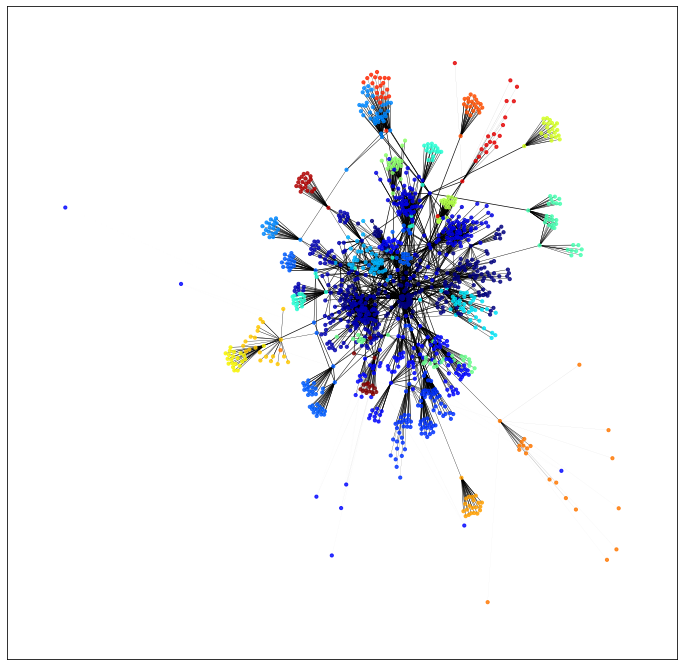

In [279]:
GG.draw()

In [18]:
def link_products(gatherer, community):
    key = "ProductNo"
    image_fp = pd.Series(
        {item.stem: item for item in Path(gatherer.source_conf["base_img_dir"]).iterdir()},
        name="ImageFilePath"
    )
    gatherer.products = gatherer.products.join(
        community, on=key).join(image_fp, on=key).dropna(subset=[
        "ImageFilePath", "Community"]).reset_index(drop=True)

In [19]:
link_products(gatherer, community)

In [20]:
DataIO().savec(gatherer, gatherer.self_save_fp)

# Building and evaluating the predictive model

Finally, we get to the stage, in which I create a model using Tensorflow's sequential API. This relatively simple model performs quite well in this task. However, before I feed the data to the model, it needs to be preprocessed,  standardized (based on the median shape) and padded whenever applicable. I use a generator to provide the inputs to the model so that my machine does not run out of memory. The model is then trained and evaluated. Finally, I obtain a new random picture to see if the model can predict the community appropriately.

In [36]:
gatherer = DataIO().loadc("LPG.pkl")

In [37]:
class ModelGenerator():
    def __init__(self, Xy, X_name, y_name, test_size=0.1):
        self.Xy = Xy
        self.y_name = y_name
        self.X_name = X_name
        self.test_size = test_size
        self.def_mode = "RGB"
    
    def get_X_y(self, set_):
        return set_[self.X_name], set_[self.y_name]

    def preprocess(self):
        train, test = train_test_split(
            self.Xy, test_size=self.test_size, random_state=94,
            stratify=self.Xy[self.y_name]
        )
        train, val = train_test_split(
            train, test_size=self.test_size/(1-self.test_size), random_state=94,
            stratify=train[self.y_name]
        )
        self.train_X, self.train_y = self.get_X_y(train)
        self.test_X, self.test_y = self.get_X_y(test)
        self.val_X, self.val_y = self.get_X_y(val)
        
    def process_img(self, i, gen_shape=False):
        i = Image.open(i)
        if i.mode != self.def_mode:
            i = i.convert(self.def_mode)
        i = np.asarray(i)
        if gen_shape:
            return i.shape
        i = tf.image.resize(
            i, size=self.median_shape[:-1], antialias=True
        ).numpy().astype(np.uint8)
        return i
    
    def get_median_shape(self):
        shapes = np.array([self.process_img(im, gen_shape=True) for im in self.Xy[self.X_name].to_numpy()])
        self.median_shape = np.median(shapes, axis=0).astype(int)
    
    def prepare_img_data(self, set_):
        return np.array([self.process_img(fp) for fp in set_])
    
    def preprocess_images(self):
        self.train_X = self.prepare_img_data(self.train_X)
        self.test_X = self.prepare_img_data(self.test_X)
        self.val_X = self.prepare_img_data(self.val_X)
        
    
    @staticmethod
    def get_steps_per_epoch(X, y, batch_size):
        if len(y) == len(X):
            return len(y) // batch_size
        else:
            raise ValueError

    def gen_sets(self, X, y, batch_size=None, repeat=True):
        if batch_size is None:
            batch_size = 1
        itr = range(self.get_steps_per_epoch(X, y, batch_size))
        while True:
            for i in itr:
                s = slice(i * batch_size, (i + 1) * batch_size)
                Xs = X[s] / np.float16(255)
                ys = y[s].to_numpy()
                yield Xs, ys
            if not repeat:
                break
    
    def build_model(self):
        model = keras.models.Sequential()
        model_params = dict(units=200, activation="selu", kernel_initializer="lecun_normal")
        model.add(keras.layers.Flatten(input_shape=self.median_shape))
        for _ in range(6):
            model.add(keras.layers.Dense(**model_params))
        model.add(keras.layers.Dense(np.unique(self.train_y).shape[0], activation="softmax"))
        epochs = 300
        batch_size = 32
        step = epochs * len(self.train_X) // batch_size
        learning_rate = keras.optimizers.schedules.ExponentialDecay(0.001, step, 0.1)
        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.Adagrad(),
            # keras.optimizers.SGD(0.01, momentum=0.9, nesterov=True),
            metrics=["accuracy"]
        )
        early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
        history = model.fit(
            self.gen_sets(self.train_X, self.train_y, batch_size=batch_size),
            epochs=epochs,
            steps_per_epoch=self.get_steps_per_epoch(self.train_X, self.train_y, batch_size),
            callbacks=[early_stopping]
        )  # validation_data=(val_X, val_y)
        self.model = model
        model.save(f'models/{str(pd.Timestamp.now()).replace(" ", "_").replace(":", "_")}.h5')

    def test_model(self):
        loss, acc = self.model.evaluate(self.gen_sets(self.test_X, self.test_y, repeat=False))
        return acc

    def predict(self, payload):
        if isinstance(payload, Path):
            payload = str(payload)
        if isinstance(payload, str):
            payload = self.process_img(payload) / np.float16(255)
        if len(payload.shape) != 4:
            payload = payload.reshape(1, *payload.shape)
        return np.around(self.model.predict(payload), 2)

In [38]:
MG = ModelGenerator(gatherer.products, "ImageFilePath", "Community")

In [39]:
MG.preprocess()

In [40]:
MG.get_median_shape()

In [41]:
MG.preprocess_images()

In [42]:
MG.build_model()

Epoch 1/300
27/27 [==============================] - 23s 814ms/step - loss: 27.3048 - accuracy: 0.0521
Epoch 2/300
27/27 [==============================] - 20s 756ms/step - loss: 5.9275 - accuracy: 0.0567
Epoch 3/300
27/27 [==============================] - 22s 828ms/step - loss: 3.9863 - accuracy: 0.0775
Epoch 4/300
27/27 [==============================] - 22s 810ms/step - loss: 3.3140 - accuracy: 0.1111
Epoch 5/300
27/27 [==============================] - 22s 809ms/step - loss: 3.1306 - accuracy: 0.1238
Epoch 6/300
27/27 [==============================] - 22s 830ms/step - loss: 3.0600 - accuracy: 0.1377
Epoch 7/300
27/27 [==============================] - 22s 797ms/step - loss: 3.0346 - accuracy: 0.1366
Epoch 8/300
27/27 [==============================] - 22s 805ms/step - loss: 2.9619 - accuracy: 0.1620
Epoch 9/300
27/27 [==============================] - 21s 767ms/step - loss: 2.9103 - accuracy: 0.1759
Epoch 10/300
27/27 [==============================] - 22s 809ms/step - loss: 2.86

In [43]:
MG.test_model()

112/112 [==============================] - 13s 112ms/step - loss: 0.9819 - accuracy: 0.7143


0.7142857164144516

In [55]:
new_image_filepath = gatherer.get_sample_image_filepath()

In [ ]:
probabilities = MG.predict(new_image_filepath)

In [80]:
probabilities

array([[0.08, 0.  , 0.02, 0.12, 0.62, 0.01, 0.  , 0.  , 0.01, 0.02, 0.  ,
        0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.02, 0.01, 0.  ,
        0.02, 0.  , 0.  ]], dtype=float32)

In [97]:
gatherer.products[gatherer.products.Community == probabilities.argmax() + 1].head(10)

,Title,Image,PriceOld,PriceNew,Quantity,Image2,ProductNo,Timestamp,Notes,ProductNoFromRec,Title2,Description,Unit,Community,ImageFilePath
44,Theo Klein Kawiarnia - zestaw dla dzieci,https://www.lidl.pl/assets/bc8dc0a98f15926947a...,NaN,101.95,None,https://www.lidl.pl/assets/01ef45708efe50438ba...,100260487,2022-03-25 13:25:39+00:00,NaN,100260487,Theo Klein Kawiarnia - zestaw dla dzieci,Właściwości wyświetlacz dotykowy do obsługi z...,None,5.0,images\100260487.jpeg
107,LUPILU® Mata edukacyjna dla niemowląt,https://www.lidl.pl/assets/gcp76c048941cc94024...,NaN,119.00,None,https://www.lidl.pl/assets/gcp09bba05dc754405e...,100342203,2022-03-25 13:26:21+00:00,✓ Rozwija koordynację ręka-oko ✓ Z efektami dź...,100342203,LUPILU® Mata edukacyjna dla niemowląt,Opis produktu ćwiczy zmysł dotyku i słu...,None,5.0,images\100342203.jpeg
112,PLAYTIVE® Kuchnia drewniana dla dzieci,https://www.lidl.pl/media/7a5b40285e235da2923e...,NaN,279.00,None,https://www.lidl.pl/media/5247d5da4179c9ae89aa...,100337528,2022-03-25 13:26:24+00:00,✓ frajda dla małych kucharzy ✓ rozwija wyobraź...,100337528,PLAYTIVE® Kuchnia drewniana dla dzieci,Opis produktu kuchnia drewniana dla dzi...,None,5.0,images\100337528.jpeg
135,Gra Gorący Ziemniak familijny,https://www.lidl.pl/assets/027ac7b8dd49a7ea73b...,53.63,51.70,None,https://www.lidl.pl/assets/a4cb7066acc20a52246...,100339477,2022-03-25 13:26:39+00:00,NaN,100339477,Gra Gorący Ziemniak familijny,Opis produktu Kto z Was potrafi najszyb...,None,5.0,images\100339477.jpeg
149,Gra Biznes po polsku,https://www.lidl.pl/assets/c655adec5c9b691a47d...,NaN,33.95,None,https://www.lidl.pl/assets/9e9f8ff8d814251d86c...,100339475,2022-03-25 13:26:47+00:00,NaN,100339475,Gra Biznes po polsku,"Opis produktu ""Biznes po polsku"" to emo...",None,5.0,images\100339475.jpeg
177,PLAYTIVE® Zabawka motoryczna Montessori z drew...,https://www.lidl.pl/assets/929f5a711a23920ffbe...,NaN,69.90,None,https://www.lidl.pl/assets/4b7b529819c35b8526b...,100337786,2022-03-25 13:27:32+00:00,NaN,100337786,PLAYTIVE® Zabawka motoryczna Montessori z drew...,"Opis produktu ""nauka przez własne doświ...",None,5.0,images\100337786.jpeg
202,"PLAYTIVE® Drewniana zabawka motoryczna, 1 sztuka",https://www.lidl.pl/assets/98b6a84352fdbc1649a...,NaN,44.99,None,https://www.lidl.pl/assets/00d9b4db156b16acb57...,100336983,2022-03-25 13:27:52+00:00,✓ Dla dzieci od 1. roku życia ✓ Rozwija motory...,100336983,"PLAYTIVE® Drewniana zabawka motoryczna, 1 sztuka",Opis produktu wbijak z ksylofonem: z l...,None,5.0,images\100336983.jpeg
218,"Trefl Ekopuzzle z bohaterami bajek 2 w 1, 1 ze...",https://www.lidl.pl/media/cd3260820a124a8d66b5...,NaN,19.99,None,https://www.lidl.pl/media/15746e3a4ad0bc2925d4...,100338986,2022-03-25 13:28:03+00:00,✓ Ekologiczne kolory ✓ Opakowanie i puzzle bez...,100338986,"Trefl Ekopuzzle z bohaterami bajek 2 w 1, 1 ze...",Opis produktu ekologiczne puzzle ECO 2 ...,None,5.0,images\100338986.jpeg
257,PLAYTIVE® Drewniany stojak z zabawkami dla nie...,https://www.lidl.pl/assets/8ec1d3232473ca97a1f...,NaN,119.00,None,https://www.lidl.pl/assets/f8a15b2e574b33978d2...,100336750,2022-03-25 13:28:32+00:00,✓ Wspiera wczesny rozwój niemowląt poprzez zabawę,100336750,PLAYTIVE® Drewniany stojak z zabawkami dla nie...,Opis produktu stojak dla niemowląt wspi...,None,5.0,images\100336750.jpeg
259,Klocki Magformers,https://www.lidl.pl/media/1923685047d365a4f35d...,NaN,92.25,None,https://www.lidl.pl/media/3bf2a92a9af87981822c...,100241908,2022-03-25 13:28:33+00:00,NaN,100241908,Klocki Magformers,Właściwości 8 trójkątów i 6 kwadratównowe kolo...,None,5.0,images\100241908.jpeg


If you look at the titles, you would notice that all the products in this community are children's accessories and toys.

Let us look at the product to see if it was classified correctly.

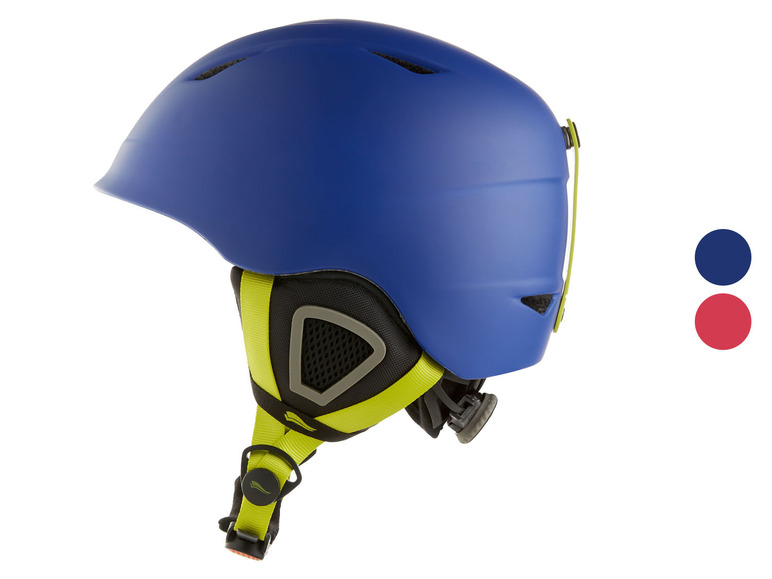

In [100]:
Image.open(new_image_filepath)

Wow, it works, that looks like a small bike helmet that could be used by a child to play! So the community has been correctly selected. We can use it to propose recommendations for this item. The power of machine learning has struck us again.

## Conclusions and limitations
As it was shown, one can avoid being blocked due to API rate limiting and still associate products with potential recommendation sets with reasonable accuracy.

Certainly, this is just a simple POC model that should be effectively substituted with a more powerful, convlution-based architecture and there is a large potential for enhancements, e.g. send API requests when the the confidence of the model is not high or the predictions do not have a clear winner. The model assumes that the communities that emerge in the recommendations would be representative of the associations among the recommended products. With this assumption, it may happen that over time the quality of the model's predicitons would deteriorate.

Another use case for the model would be its conditional usage, which might be especially relevant when one uses cloud products, such as Google Vision API. Since costs of such services may be substantial, it is reasonable to offload them with simpler solutions and use them only in cases when we are struggling with accuracy.

Thank you for reading this, please let me know if you have ideas for improvement of the model.